In [1]:
import os #Sistema operativo lo usaremos para que liste las carpetas con las imagenes
import cv2 #libreria para tratar imagenes
import tensorflow as tf #librería para redes neuronales
import numpy as np #libreria operaciones matematicas
#funciones de keras sobre tensorflow
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50    #red neuronal residual, con pesos pre entrenados 
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout #capas para redes neuronales que involucran imagenes
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator #sirve para cargar las imagenes en lotes
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt #graficos
import seaborn as sns
import pandas as pd 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [151]:
from pathlib import Path
import os
Path.cwd()
os.chdir('/content/drive/MyDrive/')

In [152]:
# Especificar el directorio del conjunto de entrenamiento
Image_Directory = 'train_'

In [ ]:
# Listar las carpetas de dicho directorio
os.listdir(Image_Directory)

In [43]:
df = pd.read_csv('train.csv')

In [177]:
df_test = pd.read_csv('/content/drive/MyDrive/train_test_data/test.csv')

In [179]:
df_test = df_test[['example_path']]

In [ ]:
df_test['Filename'] = df_test['example_path'].str.slice(start=21)

In [ ]:
df_test

In [189]:
del df_test['example_path']

In [48]:
df = df[['example_path','label']]

In [87]:
subcadena = 'train_test_data/train/'

In [117]:
df['Filename'] = df['example_path'].str.slice(start=22)

In [119]:
del df['example_path']

In [120]:
labels = df.sort_values('label')

In [ ]:
labels

In [131]:
class_names = list(labels.label.unique())

In [132]:
class_names 

[0, 1, 2]

In [124]:
class_names = ['0', '1','2']

In [126]:
for i in class_names:
    os.makedirs(os.path.join('/content/drive/MyDrive/train_',i))

In [ ]:
list(df[df['label']== 0]['Filename'])

In [76]:
import shutil 

In [137]:
list(df[df['label']== 0]['Filename'])

list

In [147]:
for i in class_names:
  for c in list(df[df['label']== i]['Filename']):    # c  ->  individual image 
  # Creating path to the image
      get_image = os.path.join('/content/drive/MyDrive/train_test_data/train/',c)
       # get_image to that path
  #if not os.path.exists('/content/drive/MyDrive/train_hackathon3/'+c+i):
            # move the image to this path
      move_image = shutil.copy(get_image,'/content/drive/MyDrive/train_/'+str(i))

In [ ]:
from PIL import Image
image_color = np.array(Image.open("train/2338.png"))
image_color

In [149]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
#se normalizan los datos (rescale) las imagenes vienen de tamaño 0 a 255 se pasan a 0 y 1
#se define el porcentaje de imagenes que se usaran como test o validación, en este caso 20%
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [153]:
# Generar lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes

#Flow_from_directory carga parcialmente las imagenes a medida que se van necesitando para no saturar la memoria, 
#shuffle = True para que seleccione aleatoriamente de cada categoria o carpeta
#Target_size para que transforme todas las imagenes y queden del mismo tamaño cuadrado 256x256, puede ser que se tengan imagenes en las carpetas de distintos tamaños
#class_mode = categorical porque es de clasificación

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= Image_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 1372 images belonging to 3 classes.


In [154]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= Image_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 342 images belonging to 3 classes.


In [155]:
# Generar un lote de 40 imágenes y etiquetas para ver un lote 
train_images, train_labels = next(train_generator)

In [156]:
#(cantidad de imagenes, pixeles de alto, pixeles de ancho, canales de color (RGB))
train_images.shape

(40, 256, 256, 3)

In [157]:
#a que categoria pertenece la imagen (única - binaria) 
train_labels.shape

(40, 3)

In [ ]:
train_labels

In [159]:
# Traductor de cada Etiqueta
label_names = {0 : 'Plantation', 1 : 'Grassland/Schrubland' , 2: 'Smallholder_Agriculture'}

# **Paso 3: Visualización del conjunto de datos**

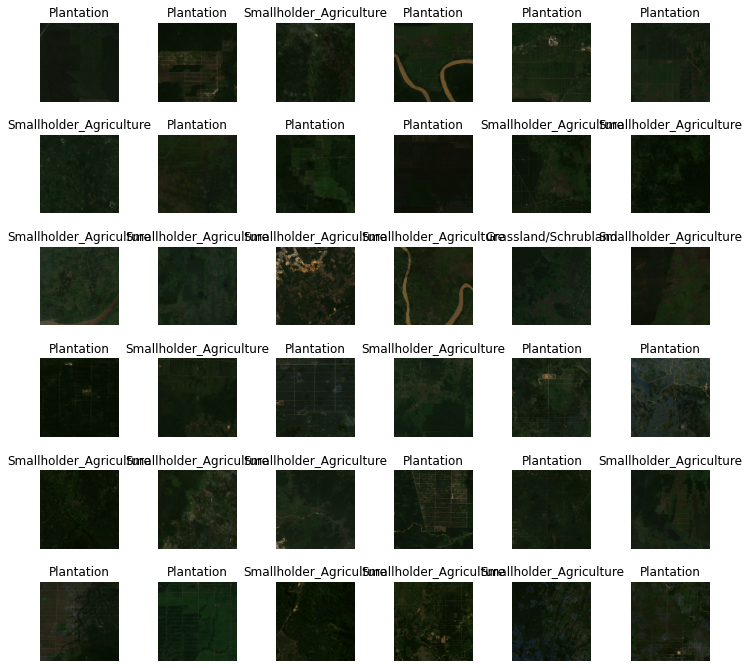

In [160]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i]) #muestra la imagen
    axes[i].set_title(label_names[np.argmax(train_labels[i])]) #muestra el nombre donde tiene asignado 1
    axes[i].axis('off') #no se necesitan los ejes

plt.subplots_adjust(wspace = 0.5)  

# **Importar el modelo base con los pesos pre-entrenados**

In [161]:
#include_top=False para que no tenga en cuenta el input de la resnet original y en input_tensor se define la forma de la entrada que vamos a usar
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

In [163]:
# Congelar el modelo hasta las últimas etapas - 10 para que no sean entrenables
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# **Construir y entrenar un modelo de deep learning**

In [164]:
#Agregamos capas adicionales partiendo del modelo base
headmodel = basemodel.output

#Pooling2D para reducir la dimensión a 4 por 4
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)

#Convertir en vector con flatten para el ingreso a la red neuronal
headmodel = Flatten(name= 'flatten')(headmodel)

#capas densas de la red neuronal para clasificación - reducción con relu de las caracteristicas negativas
headmodel = Dense(256, activation = "relu")(headmodel)

#El dropout (Universidad de Toronto) sirve para deshacerse de un % aleatorio de neuronas para evitar el sobreajuste y así evitar que la red "memorice" las imagenes
#en el entrenamiento no se debe usar el 100% de las imagenes es similar al train-test split
headmodel = Dropout(0.3)(headmodel)

#añadimos mas capas densas
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)

#añadimos mas capas densas
headmodel = Dense(64, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)

#CAPA DE SALIDA con 4 neuronas para las 4 etiquetas (covid, sano, neumonia viral o neumonia bacterial) 
#ACTIVATION = softmax para multiples categorias
headmodel = Dense(3, activation = 'softmax')(headmodel)

#DEFINIMOS EL MODELO 
model = Model(inputs = basemodel.input, outputs = headmodel)

In [172]:
#Para compilar el modelo vamos a usar la funcion de perdida categorical_crossentropy (+ de dos clases)
#algoritmo de optimización los más usados son adam y sgd, 
#pero en este caso usaremos RMSprop que castiga de igual forma el equivocarse con 
#cualquier categoria y maximiza los aciertos
#lr -> learning rate bajo para que vaya corrigiendo los pesos lentamente
#decay -> parametro de regularización pequeño para que sea suave el ajuste de los pesos


model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])


In [169]:
# Usar la parada temprana (early stopping) para salir del entrenamiento 
# si la pérdida en la validación no disminuye después de ciertas iteraciones (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [167]:
#crear los conjuntos de entrenamiento y validación utilizando el image_generator
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= Image_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= Image_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 1372 images belonging to 3 classes.
Found 342 images belonging to 3 classes.


In [173]:
#entrenamiento del modelo
#steps_per_epoch (número de pasos por ciclo) en el lote hay 428 imagenes/ 4 imagenes por lote sería 107
#train_generator.n devuelve el tamaño del generator (428) 
# // para dividir y que el resultado sea entero
#callbacks - metodos que se ejecutan cada vez que se ejecuta el ciclo
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 15, validation_data= val_generator, validation_steps= val_generator.n // 4)

Epoch 1/15
343/343 [==============================] - 54s 101ms/step - loss: 0.9810 - accuracy: 0.5598 - val_loss: 3.5418 - val_accuracy: 0.1147
Epoch 2/15
343/343 [==============================] - 33s 97ms/step - loss: 0.8166 - accuracy: 0.6749 - val_loss: 3.8397 - val_accuracy: 0.5029
Epoch 3/15
343/343 [==============================] - 34s 99ms/step - loss: 0.7290 - accuracy: 0.7296 - val_loss: 11.5214 - val_accuracy: 0.5000
Epoch 4/15
343/343 [==============================] - 34s 99ms/step - loss: 0.5973 - accuracy: 0.7930 - val_loss: 6.0001 - val_accuracy: 0.6118
Epoch 5/15
343/343 [==============================] - 35s 102ms/step - loss: 0.4946 - accuracy: 0.8258 - val_loss: 2.3738 - val_accuracy: 0.7382
Epoch 6/15
343/343 [==============================] - 33s 97ms/step - loss: 0.3918 - accuracy: 0.8848 - val_loss: 3.0358 - val_accuracy: 0.7471
Epoch 7/15
343/343 [==============================] - 34s 99ms/step - loss: 0.3528 - accuracy: 0.9045 - val_loss: 6.1661 - val_accura

# **Paso 6: Evaluar el modelo de deep learning**

In [174]:
#historial del entrenamiento
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

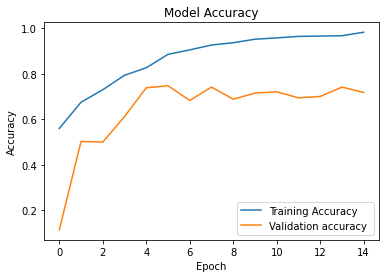

In [175]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation accuracy '])

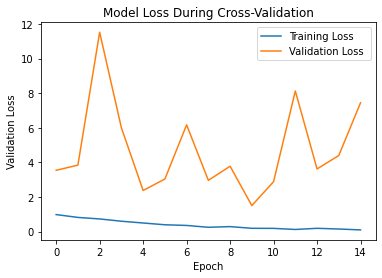

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Training Loss', 'Validation Loss '])

In [180]:
#Ahora evaluamos con el conjunto test
test_directory = '/content/drive/MyDrive/train_test_data/test'

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

In [184]:
range(len(os.listdir(test_directory)))

range(0, 635)

In [190]:
df_test

,Filename
0,69.png
1,469.png
2,6.png
3,351.png
4,1001.png
...,...
630,968.png
631,54.png
632,494.png
633,287.png


In [205]:
prediction = []
for i in list(df_test['Filename']):
  #lee cada una de las imagenes
    img= cv2.imread(os.path.join(test_directory,str(i)))
    #redimensionar a 256x256
    img = cv2.resize(img,(256,256))
    #pasar a 0 y 1
    img = img / 255
    #se hace reshape para agregar la forma que necesita la red, lote, pixel alto, pixel ancho y canal RGB
    img = img.reshape(-1,256,256,3)
    #predecir con la red
    predict = model.predict(img)
    #quedarse con la posición donde tiene 1 en la predicción
    predict = np.argmax(predict)
    #se agrega la predicción a prediction
    prediction.append(predict)


1/1 [==============================] - 0s 61ms/step


In [199]:
import json

In [206]:
df = pd.DataFrame(prediction, columns=['target'])


In [207]:
df

,target
0,2
1,2
2,2
3,2
4,0
...,...
630,2
631,2
632,2
633,0


In [224]:
predictions = df.to_json()

In [225]:
predictions

'{"target":{"0":2,"1":2,"2":2,"3":2,"4":0,"5":2,"6":0,"7":0,"8":2,"9":2,"10":2,"11":2,"12":0,"13":0,"14":2,"15":0,"16":2,"17":0,"18":0,"19":0,"20":2,"21":0,"22":2,"23":0,"24":0,"25":0,"26":2,"27":2,"28":0,"29":0,"30":0,"31":0,"32":0,"33":0,"34":2,"35":0,"36":0,"37":2,"38":2,"39":0,"40":2,"41":0,"42":0,"43":0,"44":2,"45":0,"46":0,"47":0,"48":2,"49":0,"50":0,"51":1,"52":0,"53":0,"54":2,"55":2,"56":2,"57":0,"58":0,"59":2,"60":0,"61":0,"62":0,"63":2,"64":0,"65":0,"66":2,"67":0,"68":0,"69":2,"70":2,"71":2,"72":0,"73":0,"74":0,"75":0,"76":2,"77":2,"78":0,"79":2,"80":2,"81":2,"82":0,"83":0,"84":2,"85":0,"86":2,"87":2,"88":0,"89":0,"90":2,"91":0,"92":2,"93":0,"94":0,"95":0,"96":0,"97":0,"98":0,"99":0,"100":0,"101":2,"102":0,"103":2,"104":2,"105":0,"106":2,"107":2,"108":0,"109":2,"110":0,"111":2,"112":0,"113":2,"114":1,"115":0,"116":0,"117":2,"118":2,"119":2,"120":0,"121":0,"122":2,"123":2,"124":0,"125":0,"126":2,"127":2,"128":0,"129":2,"130":0,"131":0,"132":0,"133":2,"134":0,"135":0,"136":0,"1

In [228]:
with open('predictions.json', 'w') as file:
    json.dump(predictions, file)